In [2]:
cd ../Python/

/Users/cesarosorio/Kaggle/PainterbyNumbers/fifth_floor_art_critics/Python


In [3]:
import readPBNData.description as rd
import readPBNData.images as ri

In [4]:
csvs, fileLike = rd.openZip('../Data/train_info.csv.zip')
lines, head = rd.readCSV(fileLike[0])

In [5]:
print(head)
lines[:2]

['filename', 'artist', 'title', 'style', 'genre', 'date']


[['102257.jpg',
  '5b39c876740bfc1cfaf544721c43cac3',
  'Uriel',
  'Color Field Painting',
  'abstract',
  '1955.0'],
 ['75232.jpg',
  '5b39c876740bfc1cfaf544721c43cac3',
  'Vir Heroicus Sublimis',
  'Color Field Painting',
  'abstract',
  '1950.0']]

In [7]:
cols = rd.columns(lines,head)
cols.keys()

['style', 'title', 'artist', 'filename', 'date', 'genre']

In [23]:
cols['artist'][:10]

['5b39c876740bfc1cfaf544721c43cac3',
 '5b39c876740bfc1cfaf544721c43cac3',
 '96e5bc98488ed589b9bf17ad9fd09371',
 '5b39c876740bfc1cfaf544721c43cac3',
 '5b39c876740bfc1cfaf544721c43cac3',
 '782192dc825c7c1149825adcb7caacbc',
 'afdfc43410410892bc9d1c4d3c3d6220',
 '9f0984ce62483f294fc666d74e0974f6',
 '3a40b18a78ceb822961393c50bdb522b',
 'd09f796f2b0aa11dffc88badd9806119']

In [9]:
cols['title'][:10]

['Uriel',
 'Vir Heroicus Sublimis',
 'Night March of a Hundred Demons (left half)',
 'Who\xe2\x80\x99s Afraid of Red,  Yellow and Blue II',
 'Black Fire I ',
 'Camellia and Bush Warbler',
 'Forbidden Land ',
 'Descent from the cross',
 'Snowy landscape with a woman brandishing a broom and a man holding an umbrella',
 'Storm at sea']

In [121]:
img = ri.openZipImage('../Data/train_1.zip',cols['filename'][0],prefix='train_1')

In [122]:
img.show()

In [83]:
new2= img.resize(size=(100,100))

In [90]:
print(new2.getdata())

In [108]:
new= img.resize(size=(100,100))

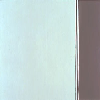

In [109]:
new

In [44]:
print(new.format, new.size, new.mode)

None (100, 100) RGB


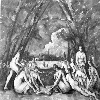

In [48]:
r, g, b = new.split()
r

In [10]:
import zipfile
import os
zf = zipfile.ZipFile('../Data/train_1.zip','r')
filenames = zf.namelist()[1:]
filenames[:10]
#print([os.path.basename(h) for h in filenames])

#os.path.basename(filenames[2])

['train_1/1.jpg',
 'train_1/10.jpg',
 'train_1/100.jpg',
 'train_1/1000.jpg',
 'train_1/10000.jpg',
 'train_1/100001.jpg',
 'train_1/100002.jpg',
 'train_1/100003.jpg',
 'train_1/100006.jpg',
 'train_1/100007.jpg']

In [11]:
len(filenames)

11025

In [14]:
import readPBNData.description as rd
import readPBNData.images as ri
from PIL import Image, ImageMath
import numpy as np

mylist=[]
for h in range(50):
    #del img, new, cleanlist
    img = ri.openZipImage('../Data/train_1.zip',filenames[h])
    new= img.resize(size=(100,100))
    cleanlist=np.array(new).flatten()
    mylist.append([cleanlist,os.path.basename(filenames[h])])
mylist=np.array(mylist)


In [49]:
import readPBNData.description as rd
import readPBNData.images as ri
from PIL import Image, ImageMath
import numpy as np

mylist2=[]
df = pd.DataFrame([])
for h in range(50):
    #del img, new, cleanlist
    img = ri.openZipImage('../Data/train_1.zip',filenames[h])
    new= img.resize(size=(100,100))
    px2 = np.array(new).reshape((-1,3))
    #cleanlist=np.array(new).flatten()
    data=[px2[:,0],px2[:,1],px2[:,2]]
    #data = pd.DataFrame({'R':px2[:,0],'G':px2[:,1],'B':px2[:,2]})
    mylist2.append(data)
mylist2=np.array(mylist)
#mylist2

In [63]:
mylist2[:,0][0]
df = pd.DataFrame({'pixels':mylist2[:,0],'filename':mylist2[:,1]})

In [64]:
df

,filename,pixels
0,1.jpg,"[255, 255, 255, 252, 252, 252, 255, 255, 255, ..."
1,10.jpg,"[113, 88, 92, 79, 49, 49, 93, 52, 46, 104, 66,..."
2,100.jpg,"[155, 139, 114, 142, 144, 131, 82, 87, 83, 77,..."
3,1000.jpg,"[140, 132, 130, 118, 130, 152, 108, 122, 161, ..."
4,10000.jpg,"[60, 69, 66, 52, 59, 69, 49, 57, 68, 48, 57, 6..."
5,100001.jpg,"[155, 125, 65, 143, 113, 53, 154, 123, 66, 150..."
6,100002.jpg,"[0, 116, 23, 0, 108, 20, 0, 103, 16, 0, 102, 1..."
7,100003.jpg,"[252, 253, 248, 250, 251, 246, 253, 252, 248, ..."
8,100006.jpg,"[121, 118, 135, 136, 137, 93, 136, 132, 85, 14..."
9,100007.jpg,"[144, 178, 205, 143, 177, 204, 134, 171, 197, ..."


In [55]:
px5 = np.array(new).reshape((-1,3))
px6 = np.array(new).reshape((-1,3))
#px2[:,0]
df5 = pd.DataFrame({'R':px5[:,0],'G':px5[:,1],'B':px5[:,2]})
df6 = pd.DataFrame({'R':px6[:,0],'G':px6[:,1],'B':px6[:,2]})
frames=[df5,df6]
result=pd.concat(frames)
result

,B,G,R
0,216,228,228
1,206,218,218
2,209,228,225
3,218,223,222
4,204,215,213
5,205,222,219
6,215,226,224
7,213,227,225
8,209,226,215
9,208,225,214


In [25]:
import pandas as pd
df = pd.DataFrame(mylist)
#df

#df = pd.DataFrame({'R':px2[:,0],'G':px2[:,1],'B':px2[:,2]})

,0,1
0,"[255, 255, 255, 252, 252, 252, 255, 255, 255, ...",1.jpg
1,"[113, 88, 92, 79, 49, 49, 93, 52, 46, 104, 66,...",10.jpg
2,"[155, 139, 114, 142, 144, 131, 82, 87, 83, 77,...",100.jpg
3,"[140, 132, 130, 118, 130, 152, 108, 122, 161, ...",1000.jpg
4,"[60, 69, 66, 52, 59, 69, 49, 57, 68, 48, 57, 6...",10000.jpg
5,"[155, 125, 65, 143, 113, 53, 154, 123, 66, 150...",100001.jpg
6,"[0, 116, 23, 0, 108, 20, 0, 103, 16, 0, 102, 1...",100002.jpg
7,"[252, 253, 248, 250, 251, 246, 253, 252, 248, ...",100003.jpg
8,"[121, 118, 135, 136, 137, 93, 136, 132, 85, 14...",100006.jpg
9,"[144, 178, 205, 143, 177, 204, 134, 171, 197, ...",100007.jpg


In [ ]:
result = pd.concat([mylist, df4], axis=1, join_axes=[df1.index])

In [81]:
mylist2=np.asarray(mylist)
#type(mylist2)
mylist2.flatten('F')

array([252, 246, 243, ...,  86,  66,  79])

In [45]:
from PIL import Image, ImageMath
#new2=ImageMath.float(g)
#new2 = ImageMath.eval('convert(a,"F")', a=g)
#new2

new2 = new.convert('F')
new2

#im1 = Image.open("image1.jpg")
#im2 = Image.open("image2.jpg")

#out = ImageMath.eval("convert(min(a, b), 'L')", a=im1, b=im2)
#out.save("result.png")

IOError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=100x100 at 0x11049CB90>

In [153]:
lfw_people.images.shape

(1288, 50, 37)

In [157]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

#lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
h, w = (100,100)

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X_train = mylist
n_features = X.shape[1]

# the label to predict is the id of the person
#y = lfw_people.target
#target_names = lfw_people.target_names
#n_classes = target_names.shape[0]

#print("Total dataset size:")
#print("n_samples: %d" % n_samples)
#print("n_features: %d" % n_features)
#print("n_classes: %d" % n_classes)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

#eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
#X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################

Automatically created module for IPython interactive environment
Extracting the top 150 eigenfaces from 10 faces
done in 0.594s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.002s


In [172]:
X_train.shape

(10, 30000)

explained variance ratio (first n components): 1.0
(10, 9)


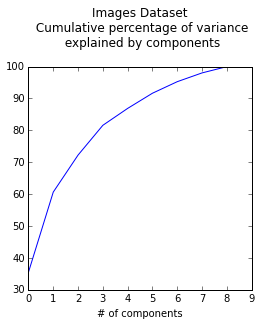

In [286]:
# Principal Component Analysis to MOvie data

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.preprocessing import scale

# Display plots inline and change default figure size
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Note that I use scale and then PCA with Whitening, because whitening eliminates
# correlation among features but scaling only affects the features independently
X_train = mylist
components= 9
pca = PCA( n_components = components,whiten=True )
#pca = RandomizedPCA(n_components = 200, random_state=0 )
X_pca = pca.fit_transform(X_train)
#X_pca = pca.fit_transform(scale(X_train))
#X_pca_test = pca.transform(scale(X_test))

# Percentage of variance explained for each components
print('explained variance ratio (first n components): %s'
      % str(sum(pca.explained_variance_ratio_)))
print(X_pca.shape)
h, w = (3,3)
eigenfaces = pca.components_.reshape((components, h, w))
#eigenvalues = pca.explained_variance_
plt.figure(figsize=(4, 4))
eigencumul=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(range(components),eigencumul)

#plt.ylim(0, 100)
plt.xlim(0, components)
#plt.ylabel('Error')
plt.xlabel('# of components')
plt.title('Images Dataset \n Cumulative percentage of variance \n explained by components \n', fontsize=12, ha='center')

In [302]:
mylist[0,:].shape.reshape(100,100,3)

AttributeError: 'tuple' object has no attribute 'reshape'

In [196]:
eigenfaces = pca.components_.reshape((9, 10000, 3))

ValueError: total size of new array must be unchanged

In [94]:
lfw_people['images'].shape

(1288, 50, 37)

In [189]:
import numpy as np
a = np.array([[1,2,3], [4,5,6],[7,8,9],[10,11,12]])
#a.flatten()
a.flatten().reshape()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [41]:
from PIL import Image, ImageMath
out = Image.convert("F", new)

AttributeError: 'module' object has no attribute 'convert'

In [ ]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.157s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s
Fitting the classifier to the training set
done in 14.776s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.042s
                   precision    recall  f1-score   support

     Ariel Sharon       0.39      0.54      0.45        13
     Colin Powell       0.78      0.87      0.82        60
  Donald Rumsfeld       0.76      0.70      0.73        27
    George W Bush       0.91      0.88      0.89       146
Gerhard Schroeder       0.77      0.80      0.7

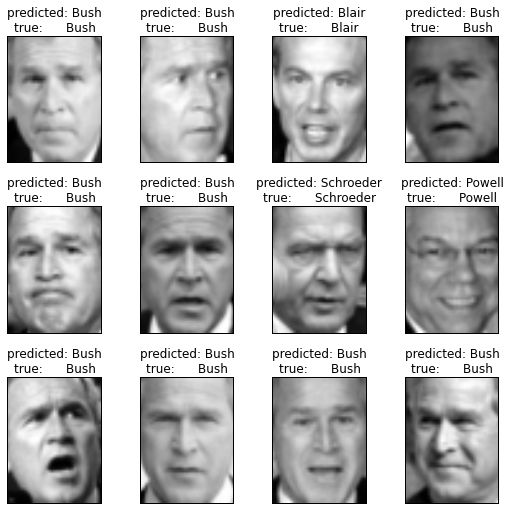

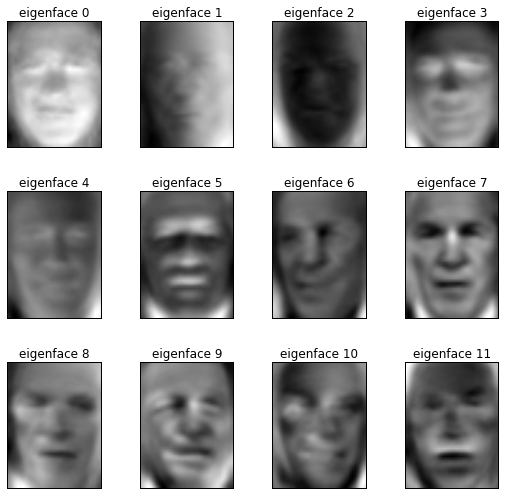

In [200]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [201]:
h

50

In [193]:
w

37

In [194]:
n_samples

1288

In [204]:
lfw_people.images[0]

(50, 37)

In [206]:
lfw_people.images.shape

(1288, 50, 37)

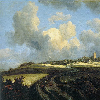

In [245]:
new

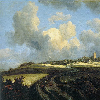

In [313]:
# Convert image to array , and then from array to image
im = np.array(new)
#im.flatten().reshape(100,100,3)
im3 = Image.fromarray(im.flatten().reshape(100,100,3))
im3

/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in sqrt
/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in divide
/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in divide


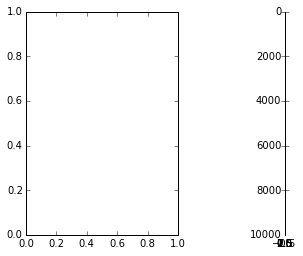

In [363]:
from PIL import Image
from numpy import *
from pylab import *
#import pca
#from sklearn.decomposition import PCA, RandomizedPCA

imlist=[array(new).reshape(-1, 3), array(new).reshape(-1, 3),array(new).reshape(-1, 3),array(new).reshape(-1, 3)]
im = imlist[0] # open one image to get size
m,n = im.shape[0:2] # get the size of the images
imnbr = len(imlist) # get the number of images

# create matrix to store all flattened images
#immatrix = array([array(Image.open(im)).flatten()
              #for j in imlist],'f')

# create matrix to store all flattened images
immatrix = array([imlist[i].flatten()
              for i in range(len(imlist))],'f')




# perform PCA

from PIL import Image
from numpy import *

def pca2(X):
  """  Principal Component Analysis
    input: X, matrix with training data stored as flattened arrays in rows
    return: projection matrix (with important dimensions first), variance
    and mean."""

  # get dimensions
  num_data,dim = X.shape

  # center data
  mean_X = X.mean(axis=0)
  #X = X - mean_X

  if dim>num_data:
    # PCA - compact trick used
    M = dot(X,X.T) # covariance matrix
    e,EV = linalg.eigh(M) # eigenvalues and eigenvectors
    tmp = dot(X.T,EV).T # this is the compact trick
    V = tmp[::-1] # reverse since last eigenvectors are the ones we want
    S = sqrt(e)[::-1] # reverse since eigenvalues are in increasing order
    for i in range(V.shape[1]):
      V[:,i] /= S
  else:
    # PCA - SVD used
    U,S,V = linalg.svd(X)
    V = V[:num_data] # only makes sense to return the first num_data

  # return the projection matrix, the variance and the mean
  return V,S,mean_X



V,S,immean = pca2(immatrix)

# show some images (mean and 7 first modes)
figure()
gray()
subplot(1,2,1)
#imshow(immean.reshape(m,n))
for i in range(1):
  subplot(1,2,i+2)
  imshow(V[i].reshape(m,n))
    
    #im3 = Image.fromarray(im.flatten().reshape(100,100,3))
    
    #im3 = Image.fromarray(im.flatten().reshape(100,100,3))
    
show()

In [322]:
im = array(new)
im.shape

(100, 100, 3)

In [255]:
immatrix
imlist=[new, new]
len(imlist)

2

In [329]:
imlist=[array(new).reshape(-1, 3), array(new).reshape(-1, 3)]
len(imlist)

2

In [331]:
#im.reshape(-1, 3).shape

imlist=[array(new).reshape(-1, 3), array(new).reshape(-1, 3)]
im = imlist[0] # open one image to get size
m,n = im.shape[0:2] # get the size of the images
imnbr = len(imlist) # get the number of images

# create matrix to store all flattened images
#immatrix = array([array(Image.open(im)).flatten()
              #for j in imlist],'f')

# create matrix to store all flattened images
immatrix = array([imlist[i].flatten()
              for i in range(len(imlist))],'f')



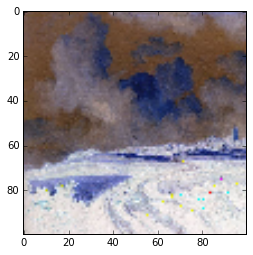

In [277]:
imshow(immean.reshape(m,n,r))

In [308]:
immatrix.mean(axis=0).shape

(30000,)

In [280]:
pca2(immatrix)[2]

/Users/cesarosorio/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in divide


(30000,)

In [284]:
V[1].reshape(m,n,r).shape

(100, 100, 3)

In [332]:
immatrix.shape

(2, 30000)

In [343]:
V.shape

(2, 30000)

In [349]:
mean_X = X.mean(axis=0)
mean_X

array([  92.71868896,   97.71647644,  107.8917923 , ...,  120.62600708,
        113.31496429,  105.59957123], dtype=float32)

In [340]:
immatrix

array([[ 144.,  178.,  205., ...,   19.,   20.,   22.],
       [ 144.,  178.,  205., ...,   19.,   20.,   22.]], dtype=float32)

In [351]:
S

array([ 34740.4765625,      0.       ], dtype=float32)

In [360]:
X=immatrix
M = dot(X,X.T)
linalg.eigh(M)

(array([  0.00000000e+00,   1.20690061e+09], dtype=float32),
 array([[-0.70710677,  0.70710677],
        [ 0.70710677,  0.70710677]], dtype=float32))

In [361]:
X.shape

(2, 30000)